In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy, MultiprocessingEvaluator)

from ema_workbench import Samplers

from dike_model_function import DikeNetwork  # @UnresolvedImport

from problem_formulation import get_model_for_problem_formulation

from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol
import SALib

import pickle

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO);

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation(2,True)

In [4]:
planning_steps

array([0, 1, 2])

In [5]:
uncertainties = dike_model.uncertainties 
outcomes = dike_model.outcomes
problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 50, 'names': ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 'A.5_pfail', 'EWS_DaysToThreat', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 133), (30, 350), (0, 3), (0, 11), (0, 11), (0, 1

In [6]:
#for unc in dike_model.uncertainties:
#    print(repr(unc))

In [7]:
#for out in dike_model.outcomes:
#    print(repr(out))

In [8]:
#for lev in dike_model.levers:
#    print(repr(lev.name))

In [9]:
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [10]:
pol = create_policy({'0_RfR 0': 0,
     '1_RfR 0': 0,
     '2_RfR 0': 0,
     '3_RfR 0': 0,
     '4_RfR 0': 0,
     'EWS_DaysToThreat': 0,
     'A.1_DikeIncrease 0': 0,
     'A.2_DikeIncrease 0': 0,
     'A.3_DikeIncrease 0': 0,
     'A.4_DikeIncrease 0': 0,
     'A.5_DikeIncrease 0': 0,},'Upstream dike, downstream rfr')

In [11]:
pol

Policy({'0_RfR 0': 0, '1_RfR 0': 0, '2_RfR 0': 0, '3_RfR 0': 0, '4_RfR 0': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.2_DikeIncrease 0': 0, 'A.3_DikeIncrease 0': 0, 'A.4_DikeIncrease 0': 0, 'A.5_DikeIncrease 0': 0})

In [12]:
policies = pol
sobol_switch = True
n_exp = 1000
   
use_pickle1 = False
if use_pickle1:
    with open('data/SOBOL_results1.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
elif sobol_switch == True :
    with MultiprocessingEvaluator(dike_model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(scenarios=n_exp, uncertainty_sampling=Samplers.SOBOL)
    
    with open('data/SOBOL_results1.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)
else: 
    with MultiprocessingEvaluator(dike_model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(scenarios=n_exp, policies = pol, uncertainty_sampling=Samplers.SOBOL)
    
    with open('data/SOBOL_results1.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)  
experiments_sobol, outcomes_sobol = results

[MainProcess/INFO] pool started with 10 workers
C:\Users\Thomas\miniconda3\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
[MainProcess/INFO] performing 102000 scenarios * 1 policies * 1 model(s) = 102000 experiments
100%|████████████████████████████████| 102000/102000 [2:12:25<00:00, 12.84it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
deaths_sobol = sobol.analyze(problem, outcomes_sobol['Expected Number of Deaths'],calc_second_order=True, print_to_console=False)
damages_sobol = sobol.analyze(problem, outcomes_sobol['Expected Annual Damage'],calc_second_order=True, print_to_console=False)

In [14]:
Si_filter = {k:deaths_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_deaths = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_deaths['ST-S1'] = Si_df_deaths['ST'] - Si_df_deaths['S1']
Si_df_deaths['Second order interaction'] = np.where(Si_df_deaths['ST-S1'] > 0.05, True, False)
Si_df_deaths_2nd = Si_df_deaths.loc[Si_df_deaths['Second order interaction'] == True]
Si_df_deaths_2nd

,ST,ST_conf,S1,S1_conf,ST-S1,Second order interaction
0_RfR 1,0.070412,0.105537,0.003341,0.015431,0.067071,True
0_RfR 2,0.072011,0.096786,-0.005703,0.008321,0.077714,True
1_RfR 2,0.049142,0.054555,-0.002782,0.004134,0.051924,True
2_RfR 0,0.055226,0.052744,0.005093,0.008736,0.050132,True
A.1_DikeIncrease 0,0.170967,0.254655,-0.004946,0.009100,0.175913,True
A.1_pfail,0.092125,0.109051,0.000995,0.009761,0.091130,True
A.2_DikeIncrease 0,0.049777,0.061887,-0.009276,0.018220,0.059052,True
A.2_pfail,0.128336,0.140735,0.034571,0.079895,0.093765,True
A.3_DikeIncrease 0,0.471613,0.566491,0.006840,0.015223,0.464773,True
A.3_pfail,0.500976,0.436528,0.036619,0.030279,0.464357,True


In [15]:
## However, the S2 dataframe shows these interactions are not very strong
#pd.set_option('display.max_columns', None)
#S2_deaths_sobol = pd.DataFrame(deaths_sobol['S2'])
#S2_deaths_sobol.fillna(0,inplace=True)
#S2_deaths_sobol
#S2_deaths_sobol_boolean = S2_deaths_sobol>0.05
#S2_deaths_sobol_boolean

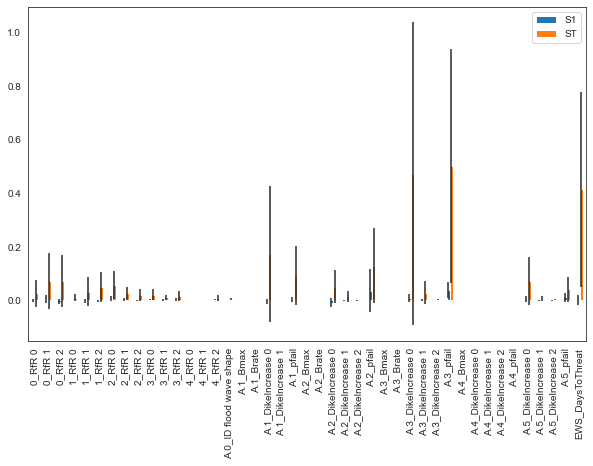

In [16]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df_deaths[['S1','ST']]
indices = indices.loc[~(Si_df_deaths==0).all(axis=1)]
err = Si_df_deaths[['S1_conf','ST_conf']]
err = err.loc[~(Si_df_deaths==0).all(axis=1)]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(10,8)
fig.subplots_adjust(bottom=0.3)
fig.savefig("sobol_deaths.png", dpi=200)
plt.show()

In [17]:
Si_filter = {k:damages_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_damages = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_damages['ST-S1'] = Si_df_damages['ST'] - Si_df_damages['S1']
Si_df_damages['Second order interaction'] = np.where(Si_df_damages['ST-S1'] > 0.05, True, False)
Si_df_damages_2nd = Si_df_damages.loc[Si_df_damages['Second order interaction'] == True]
Si_df_damages_2nd

,ST,ST_conf,S1,S1_conf,ST-S1,Second order interaction
0_RfR 1,0.131752,0.111470,-0.005393,0.023880,0.137144,True
0_RfR 2,0.114350,0.102304,-0.014788,0.022663,0.129139,True
1_RfR 0,0.087746,0.095899,0.000130,0.005895,0.087617,True
1_RfR 1,0.055438,0.061970,-0.031376,0.056785,0.086815,True
1_RfR 2,0.063095,0.064925,-0.003651,0.004749,0.066747,True
A.1_DikeIncrease 0,0.326621,0.211283,-0.006497,0.025621,0.333118,True
A.1_pfail,0.273802,0.145252,0.008198,0.032253,0.265604,True
A.3_DikeIncrease 0,0.203985,0.096096,0.022285,0.016311,0.181699,True
A.3_pfail,0.449283,0.241248,0.071941,0.047981,0.377343,True


In [18]:
#S2_damages_sobol = pd.DataFrame(damages_sobol['S2'])
#S2_damages_sobol.fillna(0,inplace=True)
#S2_damages_sobol
#S2_damages_sobol_boolean = S2_damages_sobol>0.05
#S2_damages_sobol_boolean

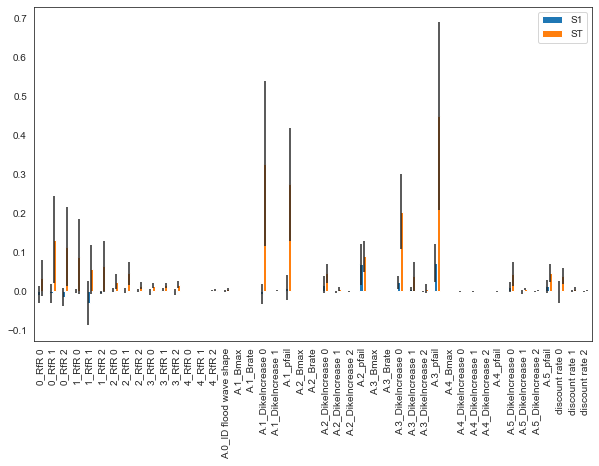

In [19]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df_damages[['S1','ST']]
indices = indices.loc[~(Si_df_damages==0).all(axis=1)]
err = Si_df_damages[['S1_conf','ST_conf']]
err = err.loc[~(Si_df_damages==0).all(axis=1)]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(10,8)
fig.subplots_adjust(bottom=0.3)
fig.savefig("sobol_damages.png", dpi=200)
plt.show()